In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Tue May 26 16:50:09 2020...


In [3]:
p_radec=np.loadtxt('radio_source.txt')

In [4]:
ch_plot=800

In [5]:
output_file='./'

In [6]:
ant='m000'
#fname='1551037708'
fname='1551055211'
#fname='1553966342'
#fname='1554156377'
#fname='1556052116'
#fname='1556138397'
#fname='1562857793'
print fname, ant

1551055211 m000


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


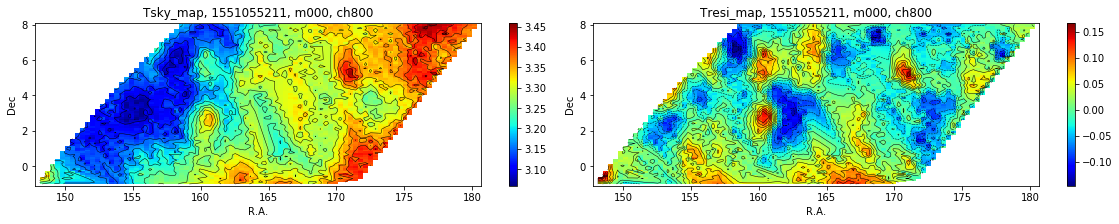

In [7]:
d1=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level4_output/data/'+str(fname)+'_'+str(ant)+'_level4_data'))
#print d.keys()

ra=d1['ra']
dec=d1['dec']
Tresi_map=d1['Tresi_map']
Tsky_map=d1['Tsky_map']

plt.figure(figsize=(20,3))
plt.subplots_adjust (wspace=0.0, hspace=0.2) 
plt.subplot(121)
p_data=Tsky_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tsky_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.subplot(122)
p_data=Tresi_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tresi_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.show()


In [8]:
#set the sky area to be pixelized 
x_cen=163 #deg #RA
x_half=20 #deg

y_cen=3.5#deg #DEC
y_half=6 #deg

pix_deg=0.3

N_half_x=int(x_half/pix_deg)
N_half_y=int(y_half/pix_deg)
Npix_x=2*N_half_x+1
Npix_y=2*N_half_y+1

print Npix_x,Npix_y

133 41


In [9]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crval = [x_cen-x_half, y_cen-y_half] # reference pointing of the image #deg
w.wcs.crpix = [1.0, 1.0] # pixel index corresponding to the reference pointing (try either 1 or 0 to see if the behaviour agrees to your expectation!)
w.wcs.cdelt = np.array([pix_deg, pix_deg]) # resolution 
w.wcs.ctype = ['RA---ZEA', 'DEC--ZEA'] #projection 
#w.wcs.ctype = ['RA---AIT', 'DEC--AIT'] #ref_p0 can't go back to zero

#other choice: https://docs.astropy.org/en/stable/wcs/
#skyview comment: https://skyview.gsfc.nasa.gov/current/help/fields.html#Projection

In [10]:
print w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 0  0


In [11]:
##check the (min ra, min dec) of sky area will fall into pix (0,0)
p0=ac.SkyCoord(ra=(x_cen-x_half)*u.deg, dec=(y_cen-y_half)*u.deg) 
ref_p=skycoord_to_pixel(p0, w)
print ref_p[0],ref_p[1]
assert(ref_p[0]<1e-12) #should be zero
assert(ref_p[1]<1e-12) #shoule be zero

0.0 0.0


In [12]:
p_list=ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg) #pointings in observation
x_pix_list,y_pix_list=skycoord_to_pixel(p_list,w) #observation (ra,dec) to pix

x_pix_list=np.round(x_pix_list).astype(int)
y_pix_list=np.round(y_pix_list).astype(int)

In [13]:
#out range due to track data, will filter when add to the map cube
print np.min(x_pix_list),np.max(x_pix_list),Npix_x
print np.min(y_pix_list),np.max(y_pix_list),Npix_y


16 146 133
4 44 41


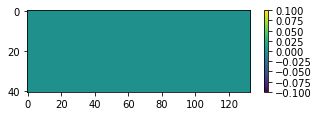

In [14]:
fits_temp=np.zeros([Npix_x,Npix_y,4096])
plt.figure(figsize=(5,1.5))
plt.imshow(fits_temp[:,:,ch_plot].T,aspect='auto')
plt.colorbar()
plt.show()

In [15]:
Sum_Tsky_xy=fits_temp.copy()
Sum_Tresi_xy=fits_temp.copy()
Npix_xy_count1=fits_temp.copy()
Npix_xy_count2=fits_temp.copy()


In [16]:
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

In [17]:
for i in range(len(ra)):
    x_pix,y_pix=x_pix_list[i],y_pix_list[i]
    
    mask1=Tsky_map.mask[i,:]
    if (mask1==True).all()==False:
        Sum_Tsky_xy[x_pix,y_pix,~mask1]+=Tsky_map[i,~mask1]
        Npix_xy_count1[x_pix,y_pix,~mask1]+=1
    
    mask2=Tresi_map.mask[i,:]
    if (mask2==True).all()==False:
        Sum_Tresi_xy[x_pix,y_pix,~mask2]+=Tresi_map[i,~mask2]
        Npix_xy_count2[x_pix,y_pix,~mask2]+=1
   

In [18]:
assert((Npix_xy_count1==Npix_xy_count2).all())

In [19]:
Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [20]:
ptr_list=ac.SkyCoord(ra=p_radec[:,0]*u.deg, dec=p_radec[:,1]*u.deg)
ptr_ra_pix,ptr_dec_pix=skycoord_to_pixel(ptr_list,w)

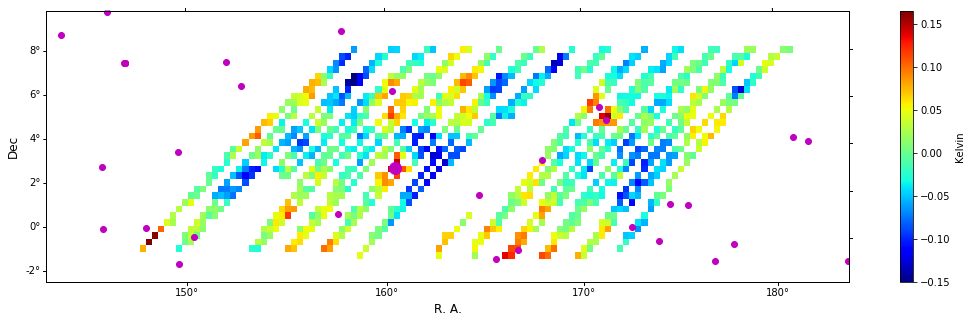

In [21]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap='jet',aspect='auto')
#plt.gca().invert_yaxis() #only works when no coordinates
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

In [22]:
assert((Npix_xy_count1==Npix_xy_count2).all())


In [23]:
print w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 0  0


In [24]:
list=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy]
list_str=['Sum_Tsky_xy','Sum_Tresi_xy','Npix_xy_count','Tsky_xy','Tresi_xy']
for i in range(len(list)):
    hdu=w.to_fits()
    hdu[0].data=list[i]
    hdu.writeto(output_file+fname+'_'+ant+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)

# reload data to check 

In [25]:
Fits='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/Tmap/'+fname+'_'+ant+'_'+list_str[-1]+'_p'+str(pix_deg)+'d.fits'
cube = fits.open(Fits)[0].data
print np.shape(cube)

(133, 41, 4096)


In [26]:
w2=WCS(Fits).dropaxis(-1)
print w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133


In [27]:
#check data
assert((cube[~np.isnan(cube)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)

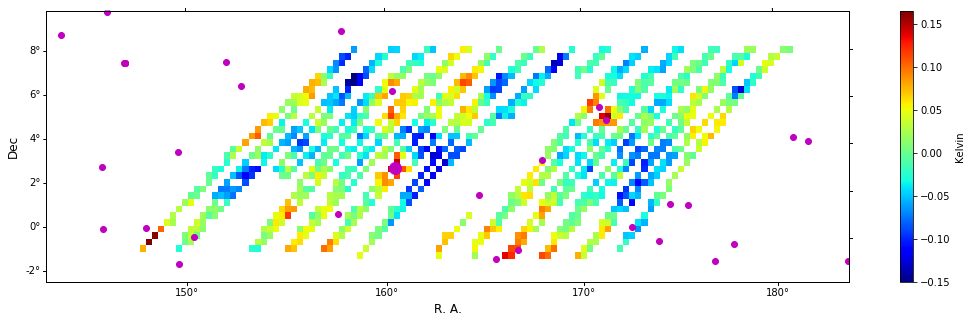

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

In [29]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Tue May 26 16:50:22 2020#
